In [49]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from IPython.display import display_html
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
from wordcloud import WordCloud

In [50]:
nltk.download('punkt')
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

In [6]:
train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [7]:
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


**Note that the data seems to lack encoded headers, first step would be to fix that. Secondly the first 2 columns seem to not add any value in terms of analyzing their sentiment**

In [9]:
train.columns = ['drop1', 'drop2', 'sentiment', 'content']
test.columns = ['drop1', 'drop2', 'sentiment', 'content']
train.drop(columns=['drop1', 'drop2'],inplace=True)
test.drop(columns=['drop1', 'drop2'],inplace=True)

train.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


**Since the missing values appear only in the training data and comprise less than 1% of its size, we can delete those rows without any risk to our modeling capabilities**

# **Data Preparation**

In [10]:
print(f'train shape :{train.shape} | test shape :{test.shape}')

train shape :(74681, 2) | test shape :(999, 2)


In [11]:
x = (train.isnull().sum() / train.shape[0]) * 100
print("Training Data %NAN:")
print(x)
z = (test.isnull().sum() / test.shape[0]) * 100
print("Testing Data %NAN:")
print(z)

Training Data %NAN:
sentiment    0.000000
content      0.918574
dtype: float64
Testing Data %NAN:
sentiment    0.0
content      0.0
dtype: float64


**Since the missing values appear only in the training data and comprise less than 1% of its size, we can delete those rows without any risk to our modeling capabilities**

In [12]:
train.dropna(inplace=True)
test.dropna(inplace=True)

org_train = train.copy()
org_test = test.copy()

The following part applies following processes
* Convert Text to Lowercase: Ensures uniformity across all text data.
* Remove Extra Spaces: Trims and standardizes spacing by eliminating multiple and trailing spaces.
* Filter Out Single Characters: Excludes all single-character words except for 'a' and 'i'.
* Remove Non-Alphabetic Characters: Strips the text of any characters that are not letters or spaces.
* Eliminate Stop Words: Removes common words that generally do not contribute to the meaning of the text.
* Return Cleaned Text: Outputs the processed text, ready for use in further NLP applications.

In [13]:
def clean_text(text):
    text = text.lower() 
    
    text = ' '.join(text.split()) 
    
    text = ' '.join([w for w in text.split() if len(w) > 1 or w in ['a', 'i']])
    
    text = ''.join([c for c in text if c.isalpha() or c.isspace()]) 
    
    stop_words = set(stopwords.words('english')) 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [14]:
data = [train, test]
for df in data:
    df['content'] = df['content'].apply(clean_text)

**lemantization and Tokenization**

* Lemmatize Text: The function lemmatizes each word in the input text. Lemmatization is the process of converting a word into its base or root form. For instance, "running" would be lemmatized to "run".
* Tokenize Text: The lemmatized text is then tokenized, splitting it back into individual words or tokens.

In [ ]:
def lemmatize_and_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    
    tokens = word_tokenize(lemmatized)
    
    return tokens

In [16]:
data = [train, test]
for df in data:
    df['content'] = df['content'].apply(lemmatize_and_tokenize)

**Finally after all the operations our train df looks like this :**

In [17]:
train.head()

,sentiment,content
0,Positive,"[coming, border, kill]"
1,Positive,"[im, getting, borderland, kill]"
2,Positive,"[im, coming, borderland, murder]"
3,Positive,"[im, getting, borderland, murder]"
4,Positive,"[im, getting, borderland, murder]"


# Data Analysis

**Word Cloud**

In [18]:
grouped_tokens = train.groupby('sentiment')['content'].sum()

In [19]:
word_freq = {sentiment: Counter(tokens) for sentiment, tokens in grouped_tokens.items()}

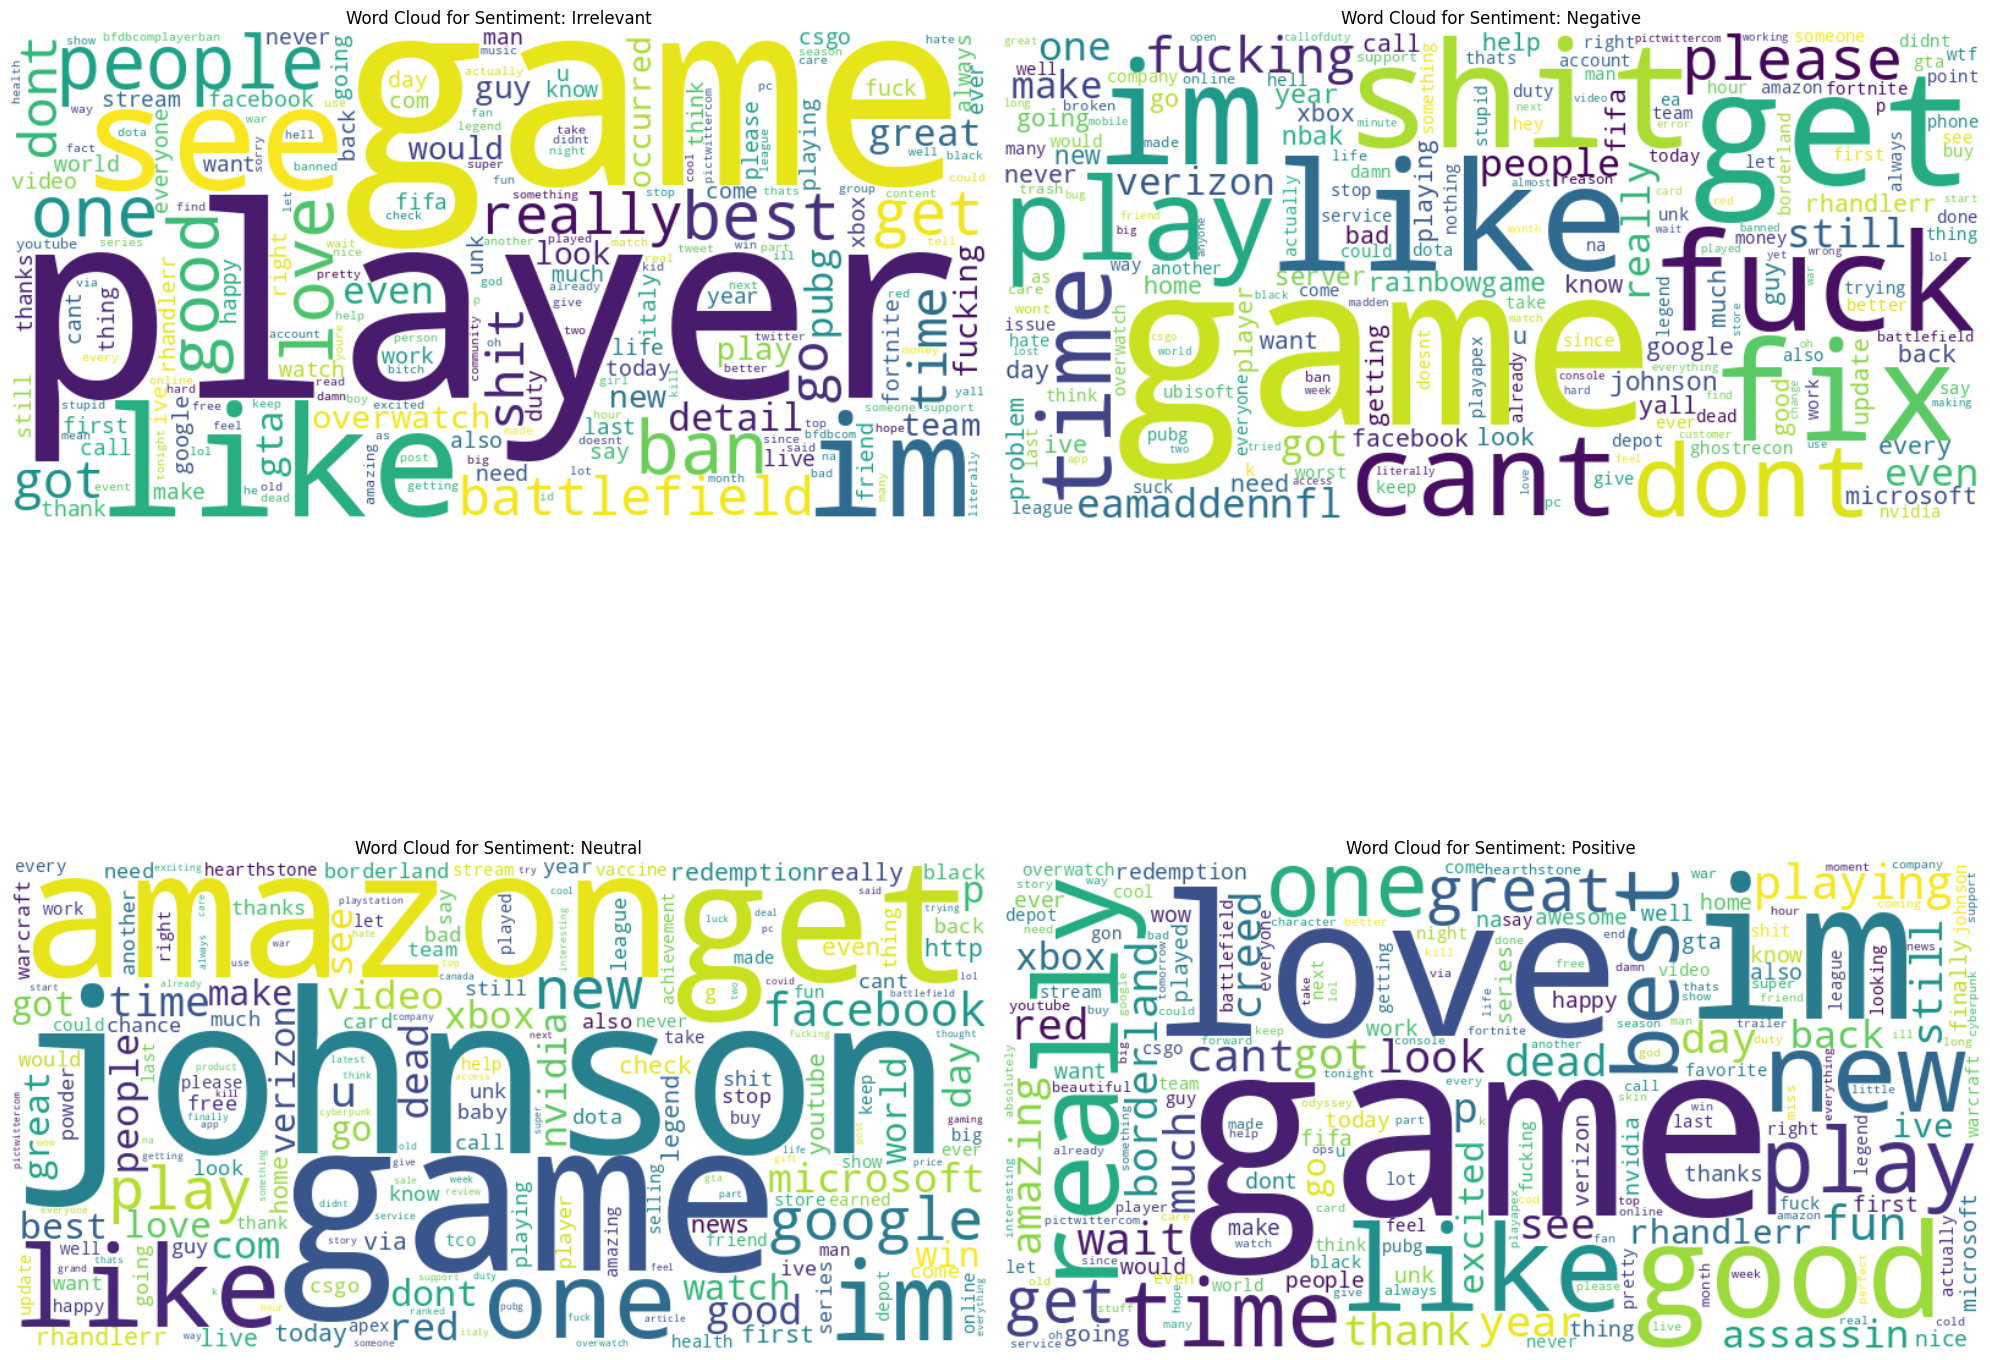

In [20]:
n_sentiments = len(word_freq)
cols = 2  
rows = (n_sentiments + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))  

for i, (sentiment, freq) in enumerate(word_freq.items()):
    ax = axes[i // cols, i % cols] 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for Sentiment: {sentiment.capitalize()}')

for j in range(i + 1, rows * cols):
    axes[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()

**From looking at this plot we can determine for our selves which words usefull and correlate highly with given sentiment**

**Positive**
Naturally words like "good", "love", "best", "like" are good predictors of positive sentiment. Other terms such as "play," "fun," and "enjoy" suggest that this sentiment includes a lot of content related to enjoyable activities or positive experiences. The presence of brand names like "amazon" and "xbox" could indicate positive mentions or recommendations of these products or services.

**Negative**
Here the prevalence of "fuck," "shit," and "fucking" highlights a strong negative emotional expression. Moreover other terms like "problem," "update," "worse," and "issue" suggest discussions around dissatisfaction, possibly related to services, products, or experiences. This sentiment seems to capture frustration or problems, as indicated by the contextually negative terms.

**Neutral** Words like "new," "watch," "series," and "google" are prominent, suggesting factual or informative content without strong emotional undertones.
This category seems to capture general discussions, possibly about media, technology, or updates, which are neither explicitly positive nor negative.

**Irrelevant** Common words like "play," "game," and "people" suggest discussions around activities, potentially gaming or recreational topics.
Words such as "shit," "fuck," and "damn" indicate strong emotions or slang usage, which might be typical in informal or passionate discussions.
The combination of positive and negative words may indicate mixed or off-topic conversations that don’t align clearly with positive or negative sentiments.

Other takeaway might be that words that exist prominently in all of these "world clouds" are actually useless and not of value for modeling a sentiment of a tweet. For example word "game" is highly common mong all of these and that seems fair scince the entities from this data set are companies that work around gaming industry. Deleting those words might help our model generalize better on this data.

**Most common words**

In [21]:
full_data = pd.concat([train, test])

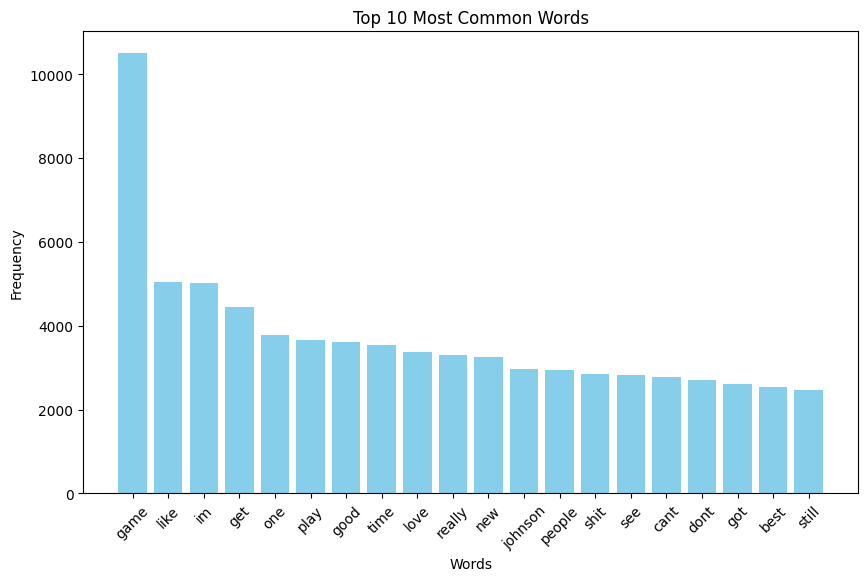

In [22]:
all_tokens = [token for sublist in full_data['content'] for token in sublist]
token_counts = Counter(all_tokens)

most_common_words = token_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

**Jaccard similarity score**

In [23]:
train['original_text'] = org_train['content'] 
test['original_text'] = org_test['content']

In [24]:
train['original_length'] = train['original_text'].apply(len)
train['cleaned_length'] = train['content'].apply(lambda x: len(' '.join(x)))

test['original_length'] = test['original_text'].apply(len)
test['cleaned_length'] = test['content'].apply(lambda x: len(' '.join(x)))

The Jaccard index ranges from 0 to 1, where 0 denotes no similarity (i.e., the sets have no elements in common) and 1 denotes maximum similarity (i.e., the sets are identical).

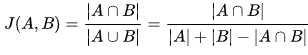

In [25]:
def jaccard_similarity_by_count(list1, list2):
    if not list1 and not list2:  
        return 1
    if not list1 or not list2:  
        return 0
    count1 = Counter(list1)
    count2 = Counter(list2)
    intersection = sum((count1 & count2).values())
    union = sum((count1 | count2).values())
    return intersection / union

In [26]:
train['jaccard_score'] = train.apply(lambda row: jaccard_similarity_by_count(row['original_text'].split(), row['content']), axis=1)
test['jaccard_score'] = test.apply(lambda row: jaccard_similarity_by_count(row['original_text'].split(), row['content']), axis=1)

In [27]:
train['jaccard_score'].describe()

count    73995.000000
mean         0.212883
std          0.151336
min          0.000000
25%          0.111111
50%          0.206897
75%          0.297297
max          1.000000
Name: jaccard_score, dtype: float64

In [28]:
zero_jaccard_df = train[train['jaccard_score'] == 0]
zero_jaccard_df.head()

,sentiment,content,original_text,original_length,cleaned_length,jaccard_score
10,Positive,[],was,3,0,0.0
11,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",94,79,0.0
12,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",94,80,0.0
13,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",93,79,0.0
14,Neutral,"[rockhard, la, vita, rare, powerful, handsome,...","Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME...",91,76,0.0


# Modelling

**For the sake of computional efficiency and simplification of the task the model will only regard Positive and Negative Sentiments**

Word Frequency Distribution:

* Tokenization: The first block of code handles tokenizing the content of the dataset, turning each piece of text into a list of words (or tokens).
* Counting Frequencies: Using Python’s Counter from the collections module, it tallies how frequently each token appears in the dataset. This results in a frequency distribution of words.
* Plotting Frequency Distribution: The plotted graph shows each word’s frequency against its rank (most to least frequent). The y-axis is logarithmic, this approach is used for such plots because word frequencies often follow a power-law distribution (Zipf's Law).

In [29]:
train_filtered = train[train['sentiment'].isin(['Positive', 'Negative'])]
test_filtered = test[test['sentiment'].isin(['Positive', 'Negative'])]

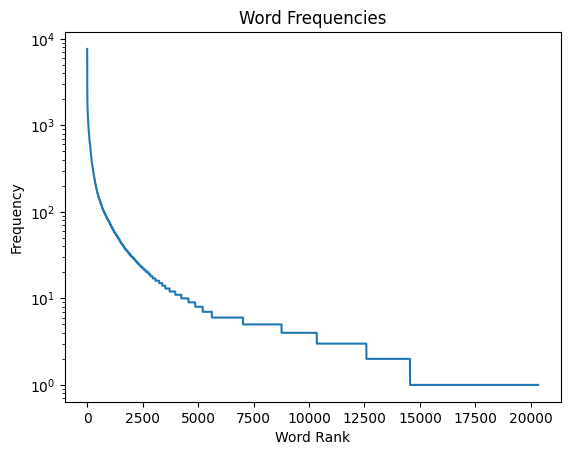

In [30]:
all_tokens = [token for sublist in train_filtered['content'] for token in sublist]
word_freq = Counter(all_tokens)

frequencies = list(word_freq.values())
frequencies.sort(reverse=True)

plt.plot(frequencies)
plt.title('Word Frequencies')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.yscale('log')  
plt.show()

Cumulative Coverage of Word Frequencies:

* Total Occurrences: This calculates the total number of word occurrences in the dataset.
* Cumulative Counts: It computes the cumulative frequency counts, meaning for any given number n, it tells you how many times the top n most frequent words appear in total.
* Plotting Cumulative Coverage: The second plot shows how much of the total text (in terms of word occurrences) is covered by the top n most frequent words. This is used for determining the point of diminishing returns where adding more words (features) contributes minimally to covering new content in the data.

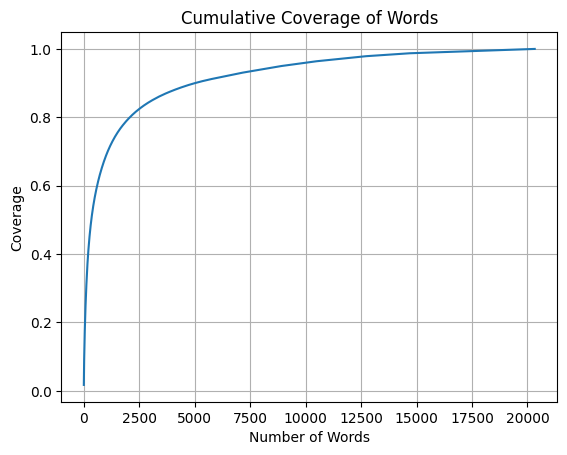

Coverage with top 1000 words: 68.77%
Coverage with top 5000 words: 89.98%
Coverage with top 7000 words: 92.88%
Coverage with top 10000 words: 95.98%
Coverage with top 15000 words: 98.80%
Coverage with top 20000 words: 99.93%


In [31]:
total_occurrences = sum(word_freq.values())
cumulative_counts = np.cumsum(sorted(word_freq.values(), reverse=True))
cumulative_coverage = cumulative_counts / total_occurrences

plt.plot(cumulative_coverage)
plt.title('Cumulative Coverage of Words')
plt.xlabel('Number of Words')
plt.ylabel('Coverage')
plt.grid(True)
plt.show()

for i in [1000, 5000, 7000, 10000, 15000, 20000]:
    coverage = cumulative_coverage[i] if i < len(cumulative_coverage) else cumulative_coverage[-1]
    print(f"Coverage with top {i} words: {coverage:.2%}")


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 7000

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')

all_tokens = [token for sublist in pd.concat([train_filtered['content'], test_filtered['content']]) for token in sublist]
tokenizer.fit_on_texts(all_tokens)

train_filtered['content'] = tokenizer.texts_to_sequences(train_filtered['content'])
test_filtered['content'] = tokenizer.texts_to_sequences(test_filtered['content'])

2024-05-20 16:49:26.560622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 16:49:26.560798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 16:49:26.733994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_33/4120232982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['content'] = tokenizer.te

In [33]:
vectorized_train = train_filtered.copy()
vectorized_test = test_filtered.copy()

Histogram of Sequence Lengths:

* The histogram displays the frequency of different sequence lengths within the dataset. Most sequences cluster around a length below 20 tokens, with frequency decreasing sharply for longer sequences. This suggests that most of the data comprises relatively short sequences.

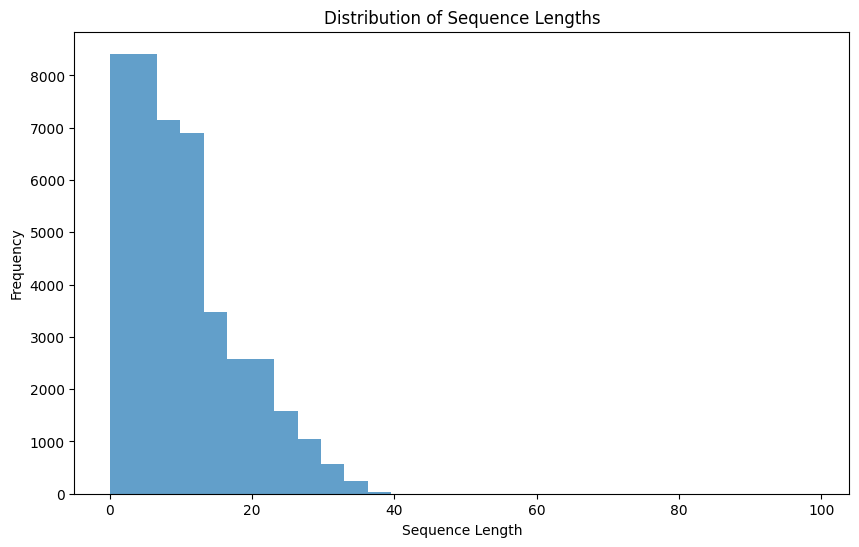

Mean length:  10.309681019250442
Median length:  8.0
Max length:  99
Min length:  0


In [34]:
lengths = [len(v) for v in vectorized_train['content']]

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

import numpy as np

print("Mean length: ", np.mean(lengths))
print("Median length: ", np.median(lengths))
print("Max length: ", np.max(lengths))
print("Min length: ", np.min(lengths))

95th Percentile Calculation:

* The script also calculates the 95th percentile of sequence lengths, which is a value below which 95% of the data fall. This metric is particularly useful for determining a cutoff or maximum sequence length for training models, allowing you to capture most of the data while ignoring extreme outliers that could skew training dynamics.

In [35]:
max_length = int(np.percentile(lengths, 95))
print("95th percentile length: ", max_length)

95th percentile length:  26


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import ast

The following code performs a series of preprocessing steps, where textual data in a DataFrame is first converted from string representations to actual data structures, then cleaned, and the DataFrame is reindexed. Sequences within the data are standardized to a uniform length using padding, labels are encoded numerically, and finally, the dataset is split into training and testing sets to prepare for machine learning model training.

In [51]:
vectorized_train['content'] = vectorized_train['content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
vectorized_test['content'] = vectorized_test['content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [52]:
vectorized_train = vectorized_train[vectorized_train['content'].apply(len) > 0]
vectorized_train.reset_index(drop=True, inplace=True)

vectorized_test = vectorized_test[vectorized_test['content'].apply(len) > 0]
vectorized_test.reset_index(drop=True, inplace=True)

In [53]:
X = pad_sequences(vectorized_train['content'], maxlen=max_length, padding='post', dtype='float32')
X_test2 = pad_sequences(vectorized_test['content'], maxlen=max_length, padding='post', dtype='float32')

In [54]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(vectorized_train['sentiment']) 
y_test2 = label_encoder.fit_transform(vectorized_test['sentiment']) 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
vocab_size = 7000
embedding_dim = 50  
max_length = 26     

**Optuna**

Optuna is an advanced hyperparameter optimization framework designed to fine-tune the parameters that govern machine learning models. At its core, Optuna utilizes a Bayesian optimization technique, particularly the Tree-structured Parzen Estimator (TPE) method, which models the probability of a hyperparameter configuration being optimal based on past trial results. This approach allows Optuna to focus on more promising areas of the hyperparameter space, enhancing the efficiency of the search process. The framework also integrates pruning mechanisms, such as the Median Pruner, which assess the performance of ongoing trials against a dynamically calculated median benchmark.

In [43]:
import optuna
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_neurons = trial.suggest_int('num_neurons', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    regularization_rate = trial.suggest_float('regularization_rate', 0.001, 0.01)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    for i in range(num_layers):
        model.add(Bidirectional(LSTM(num_neurons, return_sequences=(i < num_layers-1))))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.001,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    return min(history.history['val_loss'])

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

print('Best trial:')
best_trial = study.best_trial
print('  Value: {:.6f}'.format(best_trial.value))
print('  Params: ')
for key, value in best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-05-20 16:49:45,739] A new study created in memory with name: no-name-21927f06-5002-41db-9e83-14e9f3726b30


Epoch 1/10
507/921 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.6968 - loss: 0.5396

Next step is going to be creating the model based on the paramiters determined by Optuna

In [60]:
num_layers = 2
num_neurons = 124
dropout_rate = 0.23113088976644125
regularization_rate = 0.005990606683251042

In [59]:
def build_model(num_layers, num_neurons, dropout_rate, regularization_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    for i in range(num_layers):
        model.add(Bidirectional(LSTM(num_neurons, return_sequences=(i < num_layers - 1))))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [58]:
model = build_model(num_layers, num_neurons, dropout_rate, regularization_rate)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Training and Validation Accuracy:**
* The training accuracy is consistently higher and increases more rapidly than the validation accuracy, suggesting that the model is learning well but might be slightly overfitting to the training data. However, the gap is not very large, which is a good sign and indicates that the model generalizes reasonably well.

**Training and Validation Loss:**
* The training loss decreases consistently, which aligns with the increase in training accuracy. However, the validation loss's decrease is less smooth, indicating some variability in how the model performs on new, unseen data. This fluctuation could be a sign of the model beginning to overfit the training data, especially if these trends continue beyond the fourth epoch.

Testing the trained model on a different test set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

predictions_proba = model.predict(X_test2)
predictions = (predictions_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test2, predictions)
precision = precision_score(y_test2, predictions)
recall = recall_score(y_test2, predictions)
f1 = f1_score(y_test2, predictions)
conf_matrix = confusion_matrix(y_test2, predictions)
auc = roc_auc_score(y_test2, predictions_proba)  

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

**Accuracy**
* Value:96.13% indicates that the model correctly predicts the outcome 96.13% of the time across all classes. This is quite high, suggesting that the model performs well overall.

**Precision (0.95)**
* Definition: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It shows how reliable the model is when it predicts a positive class.
* Value: A precision of 0.95 means that when the model predicts an instance as positive, it is correct 95% of the time. This is particularly important in scenarios where the cost of a false positive is high.

**Recall (0.97)**
* Definition: Recall (or sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class. It measures the model's ability to find all the relevant cases (positives).
* Value: A recall of 0.97 indicates that the model correctly identifies 98% of all actual positives. High recall is crucial in cases where missing a positive is significantly detrimental.

**F1 Score (0.96)**
* Definition: The F1 Score is the weighted average of Precision and Recall. It is a single metric that balances both the precision and the recall.
* Value: An F1 score of 0.96 suggests a robust balance between precision and recall, indicating that the model is both accurate and reliable in identifying the positive class without an excessive number of false positives or negatives.

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions_proba = model.predict(X_test2)
predictions = (predictions_proba > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test2, predictions_proba)
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(y_test2, predictions)

plt.figure(figsize=(10, 5))

plt.subplot(1, 1, 1)  
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



**ROC Curve**: This curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

**Area Under the Curve (AUC)**: The area under the ROC curve is a measure of the model's ability to distinguish between the classes. The AUC value is prominently displayed as 0.99, indicating excellent model performance. An AUC of 1 represents a perfect model, while an AUC of 0.5 suggests no discriminative ability (equivalent to random guessing).

In [61]:
plt.figure(figsize=(6, 5))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

<Figure size 600x500 with 0 Axes>